In [26]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, mutual_info_score
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import MDS

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.datasets import mnist

import sys
import os
sys.path.append(os.path.abspath('..'))
from utils.pcode import isProperSuperset, findDifferentElements, flatten, findLargestGaps, grouping, simpleGrouping
from utils.load import inflectionpoint, gen_corr_matrix

In [2]:
color = ["red", "yellow", "green", "brown", "orange", "navy", "royalblue"]
color2_2 = [["red", "blue"], ["darkorange", "royalblue"]]
reds = ["red", "orangered", "darkorange", "crimson"]
blues = ["blue", "navy","royalblue",  "deepskyblue"]
line = ["-","--","-.", ":"]

In [17]:
def generate_labeled_dataset(dimensions, num_samples, noise_ratio):
    # The total number of noise points
    num_noise = int(num_samples * noise_ratio)
    
    # The number of samples in each cluster
    num_cluster_samples = (num_samples - num_noise) // 2
    
    # Generate random centers for the two clusters
    center_1 = np.random.rand(dimensions)
    center_2 = 10 * np.random.rand(dimensions)
    
    # Generate the clusters around the random centers
    cluster_1 = center_1 + 10 * np.random.randn(num_cluster_samples, dimensions)
    cluster_2 = center_2 + 3 * np.random.randn(num_cluster_samples, dimensions)
    
    # Generate noise
    noise = np.vstack(((center_1 + 5 * np.random.randn(num_noise // 2, dimensions)),(center_2 + 5 * np.random.randn(num_noise - num_noise // 2, dimensions))))
    # noise = np.vstack(((center_1 + 1 * np.random.randn(num_noise // 2, dimensions)),(center_2 + 1 * np.random.randn(num_noise - num_noise // 2, dimensions))))
    
    # Create labels for the clusters and noise
    labels_cluster_1 = np.zeros(num_cluster_samples)
    labels_cluster_2 = np.ones(num_cluster_samples)
    labels_noise = 2 * np.ones(num_noise)
    
    # Combine the clusters and noise
    data = np.vstack((cluster_1, cluster_2, noise))
    labels = np.concatenate((labels_cluster_1, labels_cluster_2, labels_noise))
    
    # Shuffle the dataset to mix noise and clusters
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    shuffled_data = data[indices]
    shuffled_labels = labels[indices]
    
    # Return the dataset as (vector, label)
    dataset = list(zip(shuffled_data, shuffled_labels))
    
    return dataset


Infinite values in X: False
Max value in X: 38.61812021990623
Min value in X: -31.28021899149858
[[ 20.99889159   1.82390657   8.49986443   3.58207631  -0.34833747
    1.98974853  14.33691896   5.24231766  -0.43802856 -14.85342512
    5.19090665 -15.85709404  -3.38226522  15.80210115   0.180995
   10.70042946  -3.982162     6.10923906   9.2496589    3.33570623
    3.12765009   7.14331465  -4.40334287  10.77307871 -14.56077397
   -1.18374701 -11.99867702  12.69800408  -1.32741376   6.34290838
    9.98226589 -12.80017495]
 [ -0.94230053   5.40079438  -4.05340666 -26.97550371  17.97423644
   10.17936981  17.73350108  -9.44667821  11.89238952   1.28176597
   -2.26151335  -9.9252354    7.24319158  -2.44045521  11.26319446
    2.45158311   7.50234932  14.72236057  -1.04125778 -13.07603156
   -3.93290833   0.75345677   0.43902843 -20.06218701 -11.07674192
   -6.71426869  -5.07780089   2.92793306  11.2154749   -5.42671171
    8.44512      0.38469044]
 [ -4.22331207   4.13291634   6.71516279   

/opt/conda/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


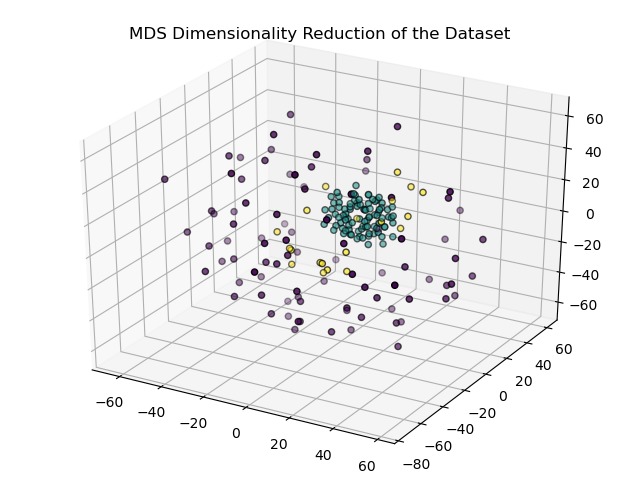

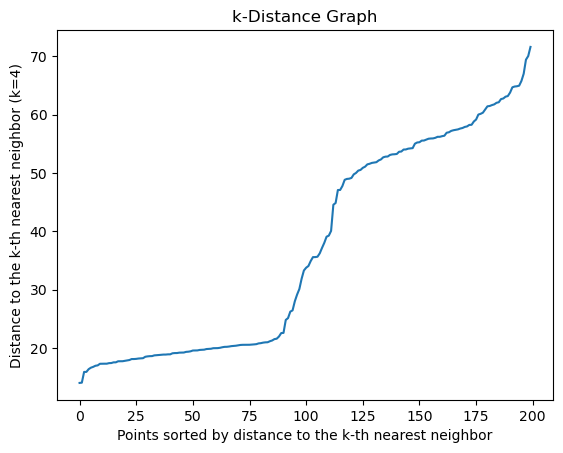

[[ 1.         75.23104828 57.57883014 ... 72.92954171 80.2226291
  56.14156247]
 [75.23104828  1.         67.20529201 ... 80.08447335 79.45710644
  65.34772065]
 [57.57883014 67.20529201  1.         ... 62.78243973 58.03301403
  26.26248855]
 ...
 [72.92954171 80.08447335 62.78243973 ...  1.         78.94514281
  70.64188611]
 [80.2226291  79.45710644 58.03301403 ... 78.94514281  1.
  60.93574716]
 [56.14156247 65.34772065 26.26248855 ... 70.64188611 60.93574716
   1.        ]]


In [31]:
%matplotlib inline
dimensions = 32  # Dimension of the feature vector
num_samples = 200  # Total number of samples
noise_ratio = 0.1  # Ratio of noise

# Generate the dataset with labels
labeled_dataset = generate_labeled_dataset(dimensions, num_samples, noise_ratio)

# Let's check the first few entries to confirm its structure
X, y = np.array([x[0] for x in labeled_dataset]), np.array([x[1] for x in labeled_dataset])
# Check for any infinite values
print("Infinite values in X:", np.any(np.isinf(X)))
# Check for any values that are too large
print("Max value in X:", np.max(X))
print("Min value in X:", np.min(X))

print(X[:5], y[:5])

sorted_distances = inflectionpoint(X)
mds = MDS(n_components=3, random_state=0)
X_mds = mds.fit_transform(X)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_mds[:, 0], X_mds[:, 1], X_mds[:,2], c=y, cmap='viridis', edgecolor='k')
plt.title("MDS Dimensionality Reduction of the Dataset")
# plt.xlabel("MDS1")
# plt.ylabel("MDS2")
# plt.colorbar(label='Class Label')
plt.show()

plt.plot(sorted_distances)
plt.xlabel('Points sorted by distance to the k-th nearest neighbor')
plt.ylabel(f'Distance to the k-th nearest neighbor (k={4})')
plt.title('k-Distance Graph')
plt.show()
print(gen_corr_matrix(X))

In [32]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
dbscan = DBSCAN(eps=20, min_samples=5)
gmm = GaussianMixture(n_components=2, random_state=0)

In [33]:
labels_phg = simpleGrouping(gen_corr_matrix(X), 2, dbg=True)
labels_kmeans = kmeans.fit_predict(X)
labels_dbscan = dbscan.fit_predict(X)
labels_gmm = gmm.fit_predict(X)

print((labels_kmeans,labels_dbscan,labels_gmm,labels_phg))

[[inf, []], [68.94495898979973, [[90, 92]]], [66.09396010895533, [[17, 23]]], [63.26459314805398, [[52, 194]]], [62.50542690793549, [[45, 137]]], [62.14367332962251, [[28, 67]]], [61.82949697493896, [[74, 149]]], [61.72088730497807, [[84, 197]]], [61.60417609858444, [[18, 196]]], [61.43088762774725, [[38, 79]]], [60.60032607863392, [[83, 141]]], [60.57006560570538, [[37, 89]]], [60.37044525963254, [[24, 113]]], [60.317597528594774, [[115, 180]]], [60.20812738857999, [[36, 91]]], [60.1913652747278, [[68, 107]]], [60.13653841677452, [[106, 134]]], [59.91618838666274, [[79, 120]]], [58.5731567320154, [[139, 157]]], [58.55936094028918, [[43, 170]]], [58.242112076607924, [[58, 165]]], [57.8280364866057, [[39, 129]]], [57.64141910954162, [[79, 128]]], [57.61670066921532, [[63, 138]]], [57.50177680445004, [[18, 167]]], [57.244824055721885, [[171, 183]]], [56.96578902219383, [[87, 150]]], [56.14028618513174, [[79, 143]]], [56.08847807878677, [[59, 141]]], [55.76443224376403, [[110, 116]]], [55

In [34]:
silhouette_kmeans = silhouette_score(X, labels_kmeans)
silhouette_dbscan = silhouette_score(X, labels_dbscan)
silhouette_gmm = silhouette_score(X, labels_gmm)
silhouette_phg = silhouette_score(X, labels_phg)

davies_bouldin_kmeans = davies_bouldin_score(X, labels_kmeans)
davies_bouldin_dbscan = davies_bouldin_score(X, labels_dbscan)
davies_bouldin_gmm = davies_bouldin_score(X, labels_gmm)
davies_bouldin_phg = davies_bouldin_score(X, labels_phg)

calinski_harabasz_kmeans = calinski_harabasz_score(X, labels_kmeans)
calinski_harabasz_dbscan = calinski_harabasz_score(X, labels_dbscan)
calinski_harabasz_gmm = calinski_harabasz_score(X, labels_gmm)
calinski_harabasz_phg = calinski_harabasz_score(X, labels_phg)

# 由于Mutual Information需要真实标签，我们使用测试集的一部分
labels_true = [0]*90+[1]*90+[2]*20
mutual_info_kmeans = mutual_info_score(labels_true, labels_kmeans)
mutual_info_dbscan = mutual_info_score(labels_true, labels_dbscan)
mutual_info_gmm = mutual_info_score(labels_true, labels_gmm)
mutual_info_phg = mutual_info_score(labels_true, labels_phg)

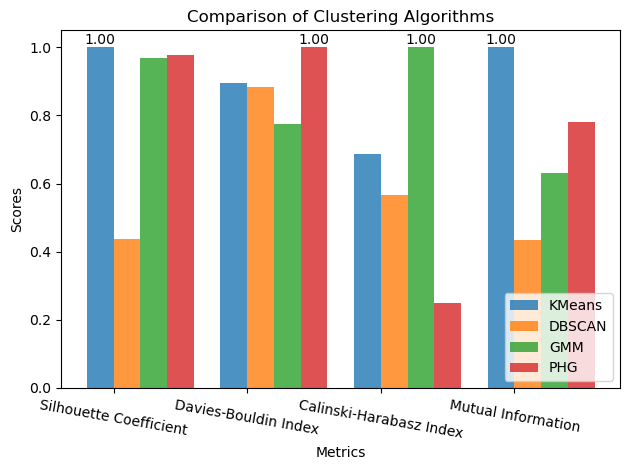

{'Silhouette Coefficient': {'KMeans': 1.0, 'DBSCAN': 0.43833541638433443, 'GMM': 0.9699763504568575, 'PHG': 0.978364148193439}, 'Davies-Bouldin Index': {'KMeans': 0.8961947938442187, 'DBSCAN': 0.8832141068238959, 'GMM': 0.7763863833657983, 'PHG': 1.0}, 'Calinski-Harabasz Index': {'KMeans': 0.6879566967366871, 'DBSCAN': 0.5671426467766276, 'GMM': 1.0, 'PHG': 0.24959882132975597}, 'Mutual Information': {'KMeans': 1.0, 'DBSCAN': 0.43348327321170216, 'GMM': 0.6316963095850322, 'PHG': 0.7798743915260592}}


In [35]:
%matplotlib inline
# 定义评价指标和算法的数据
result = {
    "Silhouette Coefficient": {
        "KMeans": silhouette_kmeans,
        "DBSCAN": silhouette_dbscan,
        "GMM": silhouette_gmm,
        "PHG": silhouette_phg
    },
    "Davies-Bouldin Index": {
        "KMeans": davies_bouldin_kmeans,
        "DBSCAN": davies_bouldin_dbscan,
        "GMM": davies_bouldin_gmm,
        "PHG": davies_bouldin_phg
    },
    "Calinski-Harabasz Index": {
        "KMeans": calinski_harabasz_kmeans,
        "DBSCAN": calinski_harabasz_dbscan,
        "GMM": calinski_harabasz_gmm,
        "PHG": calinski_harabasz_phg
    },
    "Mutual Information": {
        "KMeans": mutual_info_kmeans,
        "DBSCAN": mutual_info_dbscan,
        "GMM": mutual_info_gmm,
        "PHG": mutual_info_phg
    }
}

normalized_data = {}
for metric, scores in result.items():
    if metric == 'Davies-Bouldin Index(Reversed)':
        min_value = min(scores.values())
        normalized_data[metric] = {algo: (score - min_value) / (max(scores.values()) - min_value) for algo, score in scores.items()}
    else:
        max_value = max(scores.values())
        normalized_data[metric] = {algo: score / max_value for algo, score in scores.items()}


# 转换数据格式以便绘图
metrics = list(normalized_data.keys())
algorithms = list(normalized_data[metrics[0]].keys())
scores = {algo: [normalized_data[metric][algo] for metric in metrics] for algo in algorithms}

# 计算每个指标的最佳得分
max_scores = {
    metric: max(normalized_data[metric].values())
    for metric in metrics
}

# 绘制条形图
fig, ax = plt.subplots()
plt.xticks(rotation=-10)
bar_width = 0.2
opacity = 0.8
index = np.arange(len(metrics))

for i, algo in enumerate(algorithms):
    bars = ax.bar(index + i * bar_width, scores[algo], bar_width, alpha=opacity, label=algo)
    # 为最佳得分添加红色标注
    for bar, score, metric in zip(bars, scores[algo], metrics):
        if score == max_scores[metric]:
            # bar.set_color('red')
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(), '%.2f' % score, ha='center', va='bottom', color='black')

# 添加标签、标题和图例
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Clustering Algorithms')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)
ax.legend(loc="lower right")


# 展示图表
plt.tight_layout()
plt.show()

print(normalized_data)

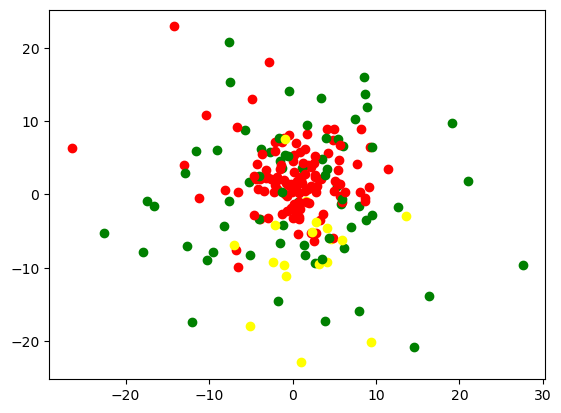

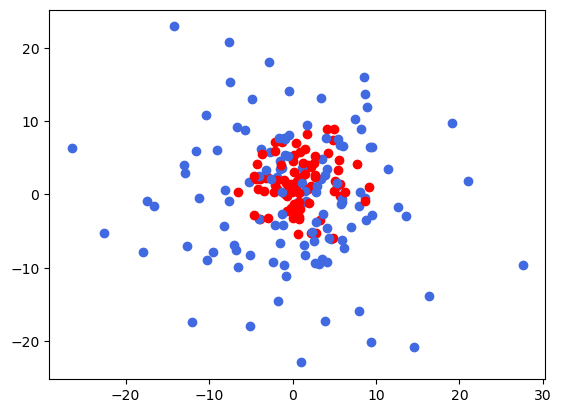

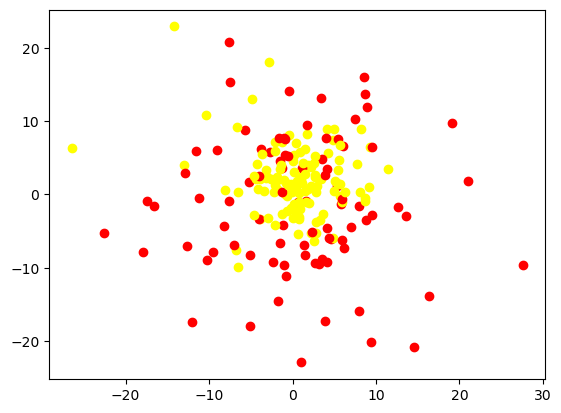

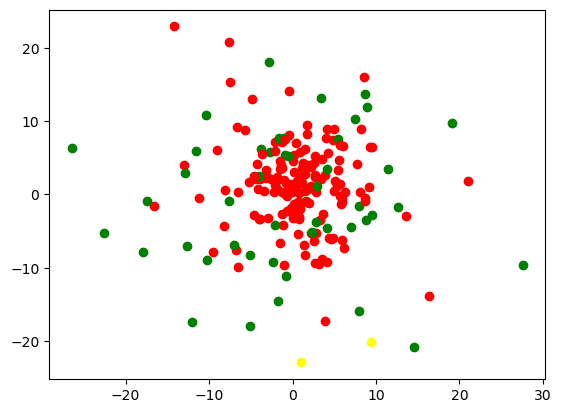

In [36]:
%matplotlib inline
fig, ax = plt.subplots()
for idx, p in enumerate(X):
    ax.scatter(p[0], p[1], c=color[labels_kmeans[idx]])
plt.show()
fig, ax = plt.subplots()
for idx, p in enumerate(X):
    ax.scatter(p[0], p[1], c=color[labels_dbscan[idx]])
plt.show()
fig, ax = plt.subplots()
for idx, p in enumerate(X):
    ax.scatter(p[0], p[1], c=color[labels_gmm[idx]])
plt.show()
fig, ax = plt.subplots()
for idx, p in enumerate(X):
    ax.scatter(p[0], p[1], c=color[labels_phg[idx]])
plt.show()